### 多层感知机(Multilayer Perceptron，MLP)
1. 仿射变换(Affine Transformation): 指在几何中，一个向量空间进行一次线性变换并接上一个平移，变换为另一个向量空间
2. 激活函数
    - ReLU函数: 
    - Sigmoid
    - Tanh

### Sigmoid 函数求导
已知: $$ s(x) = \frac{1}{1+e^{-x}} $$
令 $$ s(y) = \frac{1}{1+y}, y(z) = e^z , z(x) = -x $$
那么: $$ 
\frac{\vartheta s}{\vartheta x} = \frac{\vartheta s}{\vartheta y} \frac{\vartheta y}{\vartheta z} \frac{\vartheta z}{\vartheta x} = \frac{(1+y)^{'} - 0}{(1+y)^2} e^{z} (-1) = - \frac{1}{(1+y)^2} e^{z} $$
又因为 $$ y(s) = s^{-1} - 1 $$,
所以, $$ \frac{\vartheta s}{\vartheta x} = - \frac{1}{(1+y)^2} y = - \frac{1}{(1+ s^{-1} -1)^2} (s^{-1} - 1) $$
上下同时乘上s的平方, 可得:
$$ \frac{\vartheta s}{\vartheta x} = s(1-s) $$

### Tanh 函数求导
已知 $$ tanh(x) = \frac{1 - e^{-2x}}{1 + e^(-2x)} $$
目标: $$ tanh^{'}(x) = 1 - tanh^2(x) $$
求导: 令 $$ t(y) = \frac{1-y}{1+y}, y(z) = e^z, z(x) = -2x $$
则 $$ 
\frac{\vartheta t}{\vartheta x} = \frac{\vartheta t}{\vartheta y} \frac{\vartheta y}{\vartheta z} \frac{\vartheta z}{\vartheta x} = -2e^z \frac{(1-y){^{'} - (1+y)^{'}}}{(1+y)^2} = -2e^z \frac{-2}{(1+y)^2}
$$
因为: $$ y(z) = e^z , y(t) = \frac{1-t}{1+t} $$
所以: $$ \frac{\vartheta t}{\vartheta x} = \frac{-4y}{(1+y)^2} $$ 
将y转为t, 得: $$ \frac{\vartheta t}{\vartheta x} = 1 - t^2 = 1 - tanh^{2}x $$

In [1]:
from mxnet import autograd, nd
from IPython import display
from matplotlib import pyplot as plt

In [2]:
# 可视化 激活函数

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

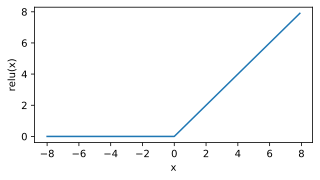

In [3]:
# ReLU
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()

with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

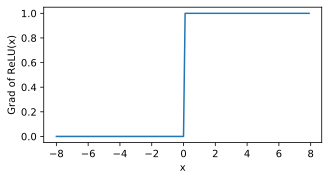

In [4]:
# 对 ReLU 求导
y.backward()
xyplot(x, x.grad, 'Grad of ReLU')  # 单位阶跃函数

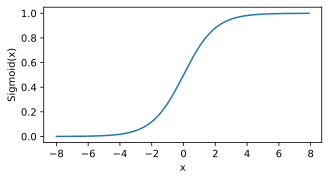

In [5]:
# Sigmoid
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'Sigmoid')

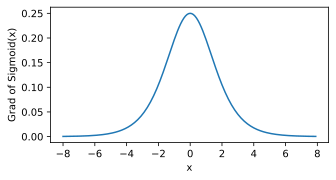

In [6]:
y.backward()
xyplot(x, x.grad, 'Grad of Sigmoid')

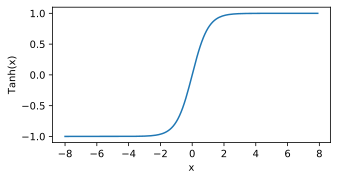

In [7]:
# tanh
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'Tanh')

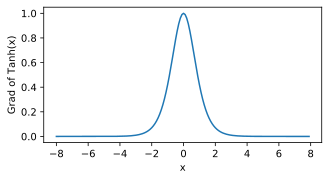

In [8]:
y.backward()
xyplot(x, x.grad, 'Grad of Tanh')

In [9]:
%matplotlib inline
import sys, time
import numpy as np
from mxnet import nd, gluon
from mxnet.gluon import loss as gloss

In [10]:
# 预处理数据

def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers
    
    
def load_data_fashion_mnist(batch_size, resize=None):
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

In [11]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [12]:
# 定义模型参数, 并初始化
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_outputs))
b2 = nd.zeros(num_outputs)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

In [13]:
# 定义激活函数
def relu(X):
    return nd.maximum(X, 0)

In [14]:
# 定义优化模型
def net(X):
    X = X.reshape((-1, num_inputs)) # 列向量
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

In [15]:
# 定义损失函数
loss = gloss.SoftmaxCrossEntropyLoss()

In [16]:
# 计算预测准确率
def accuracy(y_hat, y):
#     return (nd.argmax(y_hat) == y).sum()/y.shape[0]
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [17]:
# 评估模型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [18]:
# 训练模型
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

        
def plot_train_test_rate(train_hist, test_hist):
    x_vals = range(len(train_hist))
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals, train_hist)
    plt.plot(x_vals, test_hist)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    
        
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    train_hist = list()
    test_hist = list()
    for epoch in range(num_epochs):
        epoch_time = time.time()
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        train_acc = train_acc_sum / n
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, costs %.4f, loss %.4f, train acc %.2f%%, test acc %.2f%%'
              % (epoch + 1, time.time()-epoch_time, train_l_sum / n, train_acc * 100, test_acc * 100))
        train_hist.append(train_acc)
        test_hist.append(test_acc)
    return train_hist, test_hist

In [19]:
num_epochs, lr = 50, 0.5
train_hist, test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
          params, lr)  # 准确率好高

epoch 1, costs 3.1579, loss 0.8101, train acc 69.47%, test acc 82.27%
epoch 2, costs 2.6260, loss 0.4964, train acc 81.42%, test acc 83.83%
epoch 3, costs 2.8281, loss 0.4282, train acc 84.33%, test acc 86.01%
epoch 4, costs 3.3954, loss 0.3949, train acc 85.42%, test acc 85.78%
epoch 5, costs 3.3272, loss 0.3761, train acc 86.07%, test acc 87.44%
epoch 6, costs 3.1216, loss 0.3578, train acc 86.80%, test acc 87.69%
epoch 7, costs 3.3839, loss 0.3492, train acc 87.17%, test acc 87.83%
epoch 8, costs 3.5732, loss 0.3264, train acc 88.04%, test acc 87.71%
epoch 9, costs 3.1160, loss 0.3180, train acc 88.25%, test acc 87.75%
epoch 10, costs 3.4884, loss 0.3114, train acc 88.42%, test acc 87.81%
epoch 11, costs 3.2571, loss 0.2993, train acc 88.98%, test acc 87.94%
epoch 12, costs 3.1847, loss 0.2903, train acc 89.16%, test acc 89.08%
epoch 13, costs 3.2203, loss 0.2848, train acc 89.35%, test acc 88.34%
epoch 14, costs 3.1482, loss 0.2773, train acc 89.77%, test acc 88.60%
epoch 15, costs

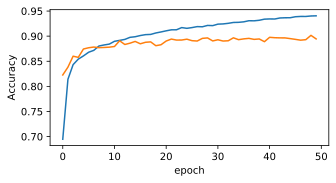

In [20]:
plot_train_test_rate(train_hist, test_hist)

In [21]:
# 中间层增减对 结果和过程的影响

### MXNet版本的多层感知机

In [22]:
from mxnet import gluon, init
from mxnet.gluon import loss as gloss, nn

In [23]:
# 定义模型
net = nn.Sequential()
net.add(nn.Dense(num_hiddens, activation='relu'), nn.Dense(num_outputs))

In [24]:
# 初始化 参数
net.initialize(init.Normal(sigma=0.01))

In [25]:
# 选择 损失函数
loss = gloss.SoftmaxCrossEntropyLoss()

In [26]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_hist, test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)

epoch 1, costs 3.1477, loss 0.8883, train acc 67.28%, test acc 82.01%
epoch 2, costs 3.4336, loss 0.5005, train acc 81.56%, test acc 81.04%
epoch 3, costs 3.7083, loss 0.4414, train acc 83.76%, test acc 85.45%
epoch 4, costs 2.9628, loss 0.4062, train acc 84.93%, test acc 85.71%
epoch 5, costs 3.1234, loss 0.3886, train acc 85.59%, test acc 86.07%
epoch 6, costs 2.9789, loss 0.3696, train acc 86.30%, test acc 86.41%
epoch 7, costs 2.8063, loss 0.3497, train acc 87.13%, test acc 87.00%
epoch 8, costs 2.8602, loss 0.3386, train acc 87.46%, test acc 87.87%
epoch 9, costs 2.8937, loss 0.3272, train acc 87.97%, test acc 87.15%
epoch 10, costs 2.9480, loss 0.3155, train acc 88.36%, test acc 87.40%
epoch 11, costs 2.8518, loss 0.3094, train acc 88.61%, test acc 88.14%
epoch 12, costs 3.0007, loss 0.3017, train acc 88.81%, test acc 88.32%
epoch 13, costs 2.8803, loss 0.2951, train acc 89.01%, test acc 88.10%
epoch 14, costs 2.8679, loss 0.2873, train acc 89.41%, test acc 88.18%
epoch 15, costs

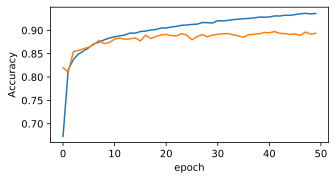

In [27]:
plot_train_test_rate(train_hist, test_hist)

### 练习
1. 隐藏层的个数/层数增减对结果有什么影响?
2. 使用其他激活函数会对 结果有什么影响? 可以对比一下

epoch 1, costs 2.6685, loss 2.1005, train acc 17.80%, test acc 21.83%
epoch 2, costs 2.0063, loss 2.1131, train acc 16.88%, test acc 10.00%
epoch 3, costs 2.0641, loss 2.3066, train acc 9.98%, test acc 10.03%
epoch 4, costs 1.9658, loss 2.3029, train acc 9.89%, test acc 10.27%
epoch 5, costs 2.3807, loss 2.2312, train acc 13.63%, test acc 10.07%
epoch 6, costs 2.1012, loss 2.1314, train acc 16.70%, test acc 10.15%
epoch 7, costs 2.4010, loss 2.2748, train acc 11.59%, test acc 9.99%
epoch 8, costs 2.2609, loss 2.3028, train acc 9.96%, test acc 10.02%
epoch 9, costs 2.5036, loss 2.3018, train acc 9.88%, test acc 11.33%
epoch 10, costs 3.2036, loss 2.1109, train acc 17.13%, test acc 23.66%
epoch 11, costs 2.2433, loss 2.0605, train acc 18.99%, test acc 23.98%
epoch 12, costs 2.0618, loss 2.1925, train acc 14.17%, test acc 9.98%
epoch 13, costs 2.2050, loss 2.2983, train acc 10.02%, test acc 17.51%
epoch 14, costs 2.0412, loss 2.1643, train acc 15.30%, test acc 25.83%
epoch 15, costs 2.181

epoch 15, costs 2.4221, loss 0.5385, train acc 81.26%, test acc 80.28%
epoch 16, costs 2.4110, loss 0.5571, train acc 80.50%, test acc 76.38%
epoch 17, costs 2.4560, loss 0.5234, train acc 81.61%, test acc 82.19%
epoch 18, costs 2.8759, loss 0.5296, train acc 81.50%, test acc 79.31%
epoch 19, costs 2.7785, loss 0.5187, train acc 81.91%, test acc 83.25%
epoch 20, costs 2.8926, loss 0.5000, train acc 82.30%, test acc 83.73%
epoch 21, costs 2.4610, loss 0.4944, train acc 82.69%, test acc 83.47%
epoch 22, costs 2.4373, loss 0.4934, train acc 82.74%, test acc 83.43%
epoch 23, costs 2.5831, loss 0.4936, train acc 82.59%, test acc 83.54%
epoch 24, costs 2.6509, loss 0.4894, train acc 82.92%, test acc 82.27%
epoch 25, costs 2.5904, loss 0.4892, train acc 82.97%, test acc 84.11%
epoch 26, costs 2.5952, loss 0.4707, train acc 83.43%, test acc 84.04%
epoch 27, costs 2.5148, loss 0.4740, train acc 83.30%, test acc 83.74%
epoch 28, costs 2.5649, loss 0.4758, train acc 83.31%, test acc 83.76%
epoch 

epoch 29, costs 2.8436, loss 0.2591, train acc 90.34%, test acc 88.20%
epoch 30, costs 2.8779, loss 0.2585, train acc 90.33%, test acc 88.42%
epoch 31, costs 2.9603, loss 0.2544, train acc 90.48%, test acc 88.51%
epoch 32, costs 3.3777, loss 0.2532, train acc 90.52%, test acc 88.53%
epoch 33, costs 3.5123, loss 0.2490, train acc 90.72%, test acc 88.53%
epoch 34, costs 3.0517, loss 0.2455, train acc 90.85%, test acc 88.54%
epoch 35, costs 2.7078, loss 0.2432, train acc 91.02%, test acc 88.04%
epoch 36, costs 3.1716, loss 0.2422, train acc 90.98%, test acc 88.28%
epoch 37, costs 2.8549, loss 0.2434, train acc 90.96%, test acc 88.76%
epoch 38, costs 2.9890, loss 0.2362, train acc 91.18%, test acc 88.84%
epoch 39, costs 2.9285, loss 0.2363, train acc 91.15%, test acc 88.48%
epoch 40, costs 2.6387, loss 0.2332, train acc 91.36%, test acc 89.15%
epoch 41, costs 2.6238, loss 0.2315, train acc 91.35%, test acc 88.82%
epoch 42, costs 2.6309, loss 0.2291, train acc 91.57%, test acc 88.82%
epoch 

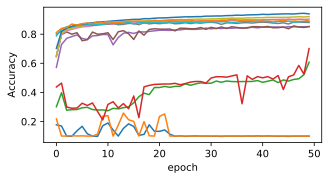

In [29]:
# 练习一: 中间层不同个数
range_of_hidden = [1, 3, 10, 30, 100, 300, 1000, 3000]
for num_of_hidden in range_of_hidden:
    # 定义 优化模型 和 激活函数
    epoch_time = time.time()
    net = nn.Sequential()
    net.add(nn.Dense(num_of_hidden, activation='relu'), nn.Dense(num_outputs))
    # 初始化参数
    net.initialize(init.Normal(sigma=0.01))
    # 定义损失函数
    loss = gloss.SoftmaxCrossEntropyLoss()
    # 开始训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    _train_hist, _test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)
    print("Num of Hidden Layers: {}, Average Time Consumming of Each Epoch: {.4f}".format(num_of_hidden, (time.time() - epoch_time) / num_epochs))
    plot_train_test_rate(_train_hist, _test_hist)

In [ ]:
# 练习一: 中间层不同层数
num_hiddens = 256
range_of_layers = range(1, 5)
for num_layer in range_of_layers:
    # 定义模型
    layers = [nn.Dense(num_hiddens, activation='relu') for _ in range(num_layer)]
    layers.append(nn.Dense(num_outputs))
    net = nn.Sequential()
    net.add(*layers)
    net.initialize(init.Normal(sigma=0.01))
        # 定义损失函数
    loss = gloss.SoftmaxCrossEntropyLoss()
    # 开始训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    _train_hist, _test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)
    print("Hidden Layers: {}, Average Time Consumming of Each Epoch: {%.4f}".format(num_of_hidden, (time.time() - epoch_time) / num_epochs))
    plot_train_test_rate(_train_hist, _test_hist)

epoch 1, costs 3.0065, loss 0.7961, train acc 70.05%, test acc 82.49%
epoch 2, costs 2.9364, loss 0.4971, train acc 81.62%, test acc 84.76%
epoch 3, costs 2.7784, loss 0.4291, train acc 84.15%, test acc 85.69%
epoch 4, costs 2.8736, loss 0.3990, train acc 85.29%, test acc 86.16%
epoch 5, costs 2.8713, loss 0.3730, train acc 86.34%, test acc 87.21%
epoch 6, costs 2.8366, loss 0.3568, train acc 86.91%, test acc 87.70%
epoch 7, costs 2.7755, loss 0.3421, train acc 87.28%, test acc 87.67%
epoch 8, costs 2.7800, loss 0.3275, train acc 87.87%, test acc 88.14%
epoch 9, costs 2.8179, loss 0.3200, train acc 88.13%, test acc 88.07%
epoch 10, costs 2.7925, loss 0.3063, train acc 88.66%, test acc 88.38%
epoch 11, costs 3.0942, loss 0.3003, train acc 88.85%, test acc 88.35%
epoch 12, costs 2.8217, loss 0.2911, train acc 89.22%, test acc 87.98%
epoch 13, costs 2.8274, loss 0.2868, train acc 89.30%, test acc 87.70%
epoch 14, costs 3.1539, loss 0.2800, train acc 89.62%, test acc 88.53%
epoch 15, costs

In [ ]:
# 练习二: 不同激活函数
num_of_hidden = 256
activation_funcs = [nn.LeakyReLU(0.05), 'linear', 'relu', 'tanh', 'sigmoid']
for acfunc in activation_funcs:
    # 定义 优化模型 和 激活函数
    epoch_time = time.time()
    net = nn.Sequential()
    net.add(nn.Dense(num_of_hidden, activation=acfunc), nn.Dense(num_outputs))
    # 初始化参数
    net.initialize(init.Normal(sigma=0.01))
    # 定义损失函数
    loss = gloss.SoftmaxCrossEntropyLoss()
    # 开始训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    _train_hist, _test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)
    print("Action Function: {}, Average Time Consumming of Each Epoch: {%.4f}".format(acfunc, (time.time() - epoch_time) / num_epochs))
    plot_train_test_rate(_train_hist, _test_hist)

### 拓展

In [ ]:
# 1. 用 mxnet的方法可视化 激活函数
def visualize_activation(activation_fn):
    data = np.linspace(-10, 10, 501)
    x = nd.array(data)
    x.attach_grad()
    with autograd.record():
        y = activation_fn(x)
    y.backward()

    plt.figure()
    plt.plot(data, y.asnumpy())
    plt.plot(data, x.grad.asnumpy())
    activation = activation_fn.name[:-1]
    plt.legend(["{} activation".format(activation), "{} gradient".format(activation)])

In [ ]:
visualize_activation(nn.Activation('relu'))

In [ ]:
visualize_activation(nn.Activation('tanh'))

In [ ]:
visualize_activation(nn.Activation('sigmoid'))

In [ ]:
visualize_activation(nn.Activation('softsign'))

In [ ]:
visualize_activation(nn.Activation('softrelu'))

In [ ]:
visualize_activation(nn.LeakyReLU(0.05))

In [ ]:
visualize_activation(nn.ELU())

In [ ]:
visualize_activation(nn.Swish())